<a href="https://colab.research.google.com/github/mondo-lee/in2HEP/blob/master/notebooks/cuts_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# path names have been modified to reflect data and classes from a forked Github repo instead of the original
#   original data is all the same (modifications are done here)
#   some functions are different
# 10-Mar-2025. Found out that to change required custom classes, one must restart the kernel.
from pathlib import Path

data_path = Path('../data-v2/VHbb_data_2jet.csv')
data_train_path = Path('../data-v2/VHbb_data_2jet_train.csv')
data_val_path = Path('../data-v2/VHbb_data_2jet_val.csv')
data_test_path = Path('../data-v2/VHbb_data_2jet_test.csv')
class_path = Path('ucl_masterclass.py')

In [2]:
# to restore verbose output, remove -nv option.
def download_data(path):
  data_path = Path(path)

  if not data_path.exists():
    bash_path = 'https://raw.githubusercontent.com/mondo-lee/in2HEP/master' + path.strip('.')
    !wget -nv -P ../data-v2/ "$bash_path"
  else:
    print("Data file already found")

In [3]:
# to restore verbose output, remove -nv option.
for path in ['', '_train', '_val', '_test']:
  download_data('../data-v2/VHbb_data_2jet' + path + '.csv')

if not class_path.exists():
    !wget -nv https://raw.githubusercontent.com/mondo-lee/in2HEP/master/notebooks/ucl_masterclass.py
else:
    print("Required custom classes already found")

2025-03-10 05:12:34 URL:https://raw.githubusercontent.com/mondo-lee/in2HEP/master/data-v2/VHbb_data_2jet.csv [41125108/41125108] -> "../data-v2/VHbb_data_2jet.csv" [1]
2025-03-10 05:12:35 URL:https://raw.githubusercontent.com/mondo-lee/in2HEP/master/data-v2/VHbb_data_2jet_train.csv [28786380/28786380] -> "../data-v2/VHbb_data_2jet_train.csv" [1]
2025-03-10 05:12:36 URL:https://raw.githubusercontent.com/mondo-lee/in2HEP/master/data-v2/VHbb_data_2jet_val.csv [6169265/6169265] -> "../data-v2/VHbb_data_2jet_val.csv" [1]
2025-03-10 05:12:36 URL:https://raw.githubusercontent.com/mondo-lee/in2HEP/master/data-v2/VHbb_data_2jet_test.csv [6209315/6209315] -> "../data-v2/VHbb_data_2jet_test.csv" [1]
2025-03-10 05:12:37 URL:https://raw.githubusercontent.com/mondo-lee/in2HEP/master/notebooks/ucl_masterclass.py [30234/30234] -> "ucl_masterclass.py" [1]


Considering some EDA:
- histogram plots
- covariance


In [4]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from copy import deepcopy
from ucl_masterclass import *

from tqdm import tqdm

In [205]:
# Load data into a pandas data frame
def load_data(path):
  '''
  Returns two copies of a csv in Pandas Dataframe format given its path in the repo, relative to the notebook.
  Will drop irrelevant columns and reorder to match table in intro notebook.
  '''
  df = pd.read_csv(path)

  # dropping unusable columns (including 'nJ' and 'nTags' since these are constant (2) in our dataset)
  # hopefully this doesn't break anything...?
      # 10-Mar-2025 update: apparently something was broken,
      #                     put 'nJ' back in - bdt_plot() uses this column (whyyyyyyyyyy)
  # 'category' is kept in for now, because I can't tell what it means
  # 'sample', 'EventWeight', 'Class', 'post_fit_weight', 'category' and 'training_weight' aren't input features but can still be used to inform decisions
  # I'm hoping that the unnamed columns aren't all former index columns
  print(list(df.columns))

  cols_to_remove = ['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0',
                  'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
                  'Unnamed: 0.1.1.1.1', 'EventNumber',
                  'MV1cJ3_cont', 'nTags', 'pTJ3', 'mBBJ',
                  'dPhiLBmin', 'MV1cJ3'] # 'nJ'

  df = df.drop(cols_to_remove,axis=1)

  # reordering columns to match table in intro notebook, moving the columns that cannot be used as input features to the front
  new_col_order = ['sample','category','EventWeight',
                  'post_fit_weight','training_weight', 'Class',
                  'nJ', 'dRBB', 'pTB1', 'pTB2', 'pTV', 'mBB', 'Mtop',
                  'mTW', 'MET', 'dYWH', 'dPhiVBB', 'MV1cB1_cont', 'MV1cB2_cont']

  df = df[new_col_order]

  df_original = deepcopy(df)

  return df, df_original

In [206]:
df      , df_original       = load_data('../data-v2/VHbb_data_2jet.csv')
df_train, df_train_original = load_data('../data-v2/VHbb_data_2jet_train.csv')
df_val  , df_val_original   = load_data('../data-v2/VHbb_data_2jet_val.csv')
df_test , df_test_original  = load_data('../data-v2/VHbb_data_2jet_test.csv')

['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1', 'nJ', 'EventNumber', 'sample', 'EventWeight', 'dYWH', 'MV1cJ3_cont', 'dPhiVBB', 'pTB2', 'nTags', 'mBB', 'MV1cB1', 'MV1cB2', 'pTV', 'MV1cB1_cont', 'nTrackJetsOR', 'pTB1', 'pTJ3', 'mBBJ', 'MV1cB2_cont', 'mTW', 'dRBB', 'MET', 'Mtop', 'dPhiLBmin', 'MV1cJ3', 'Class', 'post_fit_weight', 'category', 'training_weight']
['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1', 'nJ', 'EventNumber', 'sample', 'EventWeight', 'dYWH', 'MV1cJ3_cont', 'dPhiVBB', 'pTB2', 'nTags', 'mBB', 'MV1cB1', 'MV1cB2', 'pTV', 'MV1cB1_cont', 'nTrackJetsOR', 'pTB1', 'pTJ3', 'mBBJ', 'MV1cB2_cont', 'mTW', 'dRBB', 'MET', 'Mtop', 'dPhiLBmin', 'MV1cJ3', 'Class', 'post_fit_weight', 'category', 'training_weight']
['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1', 'nJ',

In [68]:
print(f"Entire dataset size: {len(df)}",
      f"Train set size     : {len(df_train)}",
      f"Validation set size: {len(df_val)}",
      f"Test set size      : {len(df_test)}",
      f"Sum of TVT sets    : {len(df_train) + len(df_val) + len(df_test)}",sep='\n')

Entire dataset size: 110252
Train set size     : 77176
Validation set size: 16538
Test set size      : 16538
Sum of TVT sets    : 110252


Had previously messed around with cuts on the whole dataset (train, val and test), and then subsequently only the train set. Sensitivities saw a significant decrease, so now I'm digging through certain sample subcategories and plotting the proportion of different samples in each partition to see if there is any asymmetry in the data.


In [80]:
for i, df in enumerate([df, df_train, df_val, df_train]):
  print(f"{['Entire', 'Train', 'Validation', 'Test'][i]} set:")
  ggZvvEvents = df[df['sample'] == 'ggZvvH125']
  if len(ggZvvEvents) != 0:
    print(df[df['sample'] == 'ggZvvH125'])
  else:
    print('Empty')
  print('\n\n')

Entire set:
          sample category  EventWeight  post_fit_weight  training_weight  \
67811  ggZvvH125       VH     0.001458         0.001458         2.210467   

       Class  nJ      dRBB          pTB1          pTB2           pTV  \
67811    1.0   2  1.757013  85909.984375  81317.953125  156631.28125   

               mBB          Mtop           mTW          MET      dYWH  \
67811  134020.0625  316388.84375  369374.28125  278480.6875  0.091238   

        dPhiVBB  MV1cB1_cont  MV1cB2_cont  
67811  3.055459     0.999906     0.999239  



Train set:
          sample category  EventWeight  post_fit_weight  training_weight  \
67811  ggZvvH125       VH     0.001458         0.001458         2.210467   

       Class  nJ      dRBB          pTB1          pTB2           pTV  \
67811    1.0   2  1.757013  85909.984375  81317.953125  156631.28125   

               mBB          Mtop           mTW          MET      dYWH  \
67811  134020.0625  316388.84375  369374.28125  278480.6875  0.091238 

Interestingly, there seems to only be one event in the `ggZvvH125` sample, which appears in both the train and test sets.

Since the three partitions have lengths that add up to the total dataset, this also implies that at least 1 piece of data has been omitted from the original dataset, unless there are duplicate values in the test set.

In [87]:
overall_set_size = len(df)
overall_unique_entries = len(df.drop_duplicates())

print(f'Overall set size: {overall_set_size}',
      f'Unique entries  : {overall_unique_entries}',
      f'Duplicates      : {overall_set_size - overall_unique_entries}',
      sep='\n')

Overall set size: 77176
Unique entries  : 76971
Duplicates      : 205


So uh, this is awkward.

I'm guessing there's some sort of rationale behind these duplicate values, but before I ask anybody about the actual details of the dataset I'll just augment the overall dataset with the `is_duplicate` column, inspect the duplicates and try to find commonalities :P

From what I've looked through:
- they are all unique (i.e. there are no triply-duplicated values in the overall dataset)
- they're all of the `VH` category, in the `ggZllH125` (dilepton) sample,
- thus trivially in the `1` class (involves Higgs decay),
- through `sns.histplot` calls, compared to other `ggZllH125` events, there doesn't seem to be a significant difference (confirmed via [2-sample](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html) [KS-test](https://stackoverflow.com/a/10884762), could do additional [2-sample t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)?) between the `mBB`, `dRBB` and `Mtop` variables of duplicate and non-duplicate events.

In [166]:
df['is_duplicate'] = df.duplicated(keep=False) # removes all duplicates, even if first instance
duplicates = df[df['is_duplicate']].drop_duplicates() # drops one of each duplicate pair
print(f"There are {len(duplicates)} duplicates in our dataset.")

There are 205 duplicates in our dataset.


In [164]:
print(duplicates['category'].describe())
print('\n')
print(duplicates['sample'].describe())
print('\n')
print(duplicates['Class'].unique())

count     205
unique      1
top        VH
freq      205
Name: category, dtype: object


count           205
unique            1
top       ggZllH125
freq            205
Name: sample, dtype: object


[1.]


<Axes: xlabel='dRBB', ylabel='Proportion'>

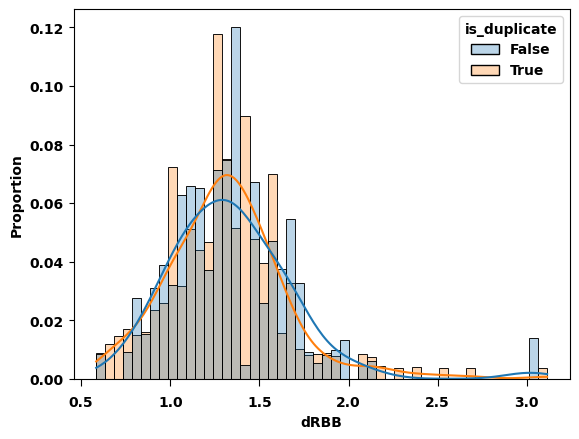

In [194]:
sns.histplot(data = df[df['sample'] == 'ggZllH125'], x='dRBB', hue = 'is_duplicate',
             alpha=0.3, weights = df[df['sample'] == 'ggZllH125']['EventWeight'],
             stat='proportion', bins=50, common_norm=False, kde=True)

In [185]:
nonduplicates =  df[(df['sample'] == 'ggZllH125') & (~df['is_duplicate'])] # only those from the same sample

print(len(df[(df['sample'] == 'ggZllH125')]))
print(len(nonduplicates))
print(len(duplicates))

576
166
205


In [199]:
from scipy.stats import ks_2samp
alpha = 0.05 # critical value

In [200]:
for column in ['mBB', 'dRBB', 'Mtop']:
  print(column)
  ks_res = ks_2samp(duplicates[column], nonduplicates[column])
  print(f"P-value: {ks_res.pvalue}")
  if ks_res.pvalue < alpha:
    print("Null hypothesis rejected: population distributions significantly different")
  else:
    print("Failed to reject null hypothesis, results inconclusive.")
  print('\n')

mBB
P-value: 0.1448257300106237
Failed to reject null hypothesis, results inconclusive.


dRBB
P-value: 0.72262471377131
Failed to reject null hypothesis, results inconclusive.


Mtop
P-value: 0.17130549018265478
Failed to reject null hypothesis, results inconclusive.




I've unfortunately already spent an egregious amount of time on what is technically irrelevant to both tasks, so I'll leave this for later.

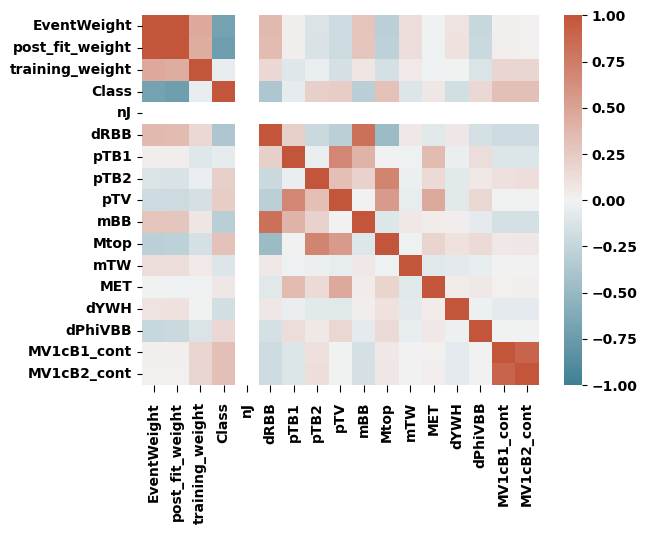

In [29]:
sns.heatmap(df_train.corr(numeric_only=True),
            vmin=-1,vmax=1,
            cmap=sns.diverging_palette(220, 20, as_cmap=True));
plt.show()

In [30]:
print(df_train.corr(numeric_only=True)['post_fit_weight']['EventWeight'])
print(df_train.corr(numeric_only=True)['MV1cB1_cont']['MV1cB2_cont'])

0.9921913685338899
0.9042951796288364


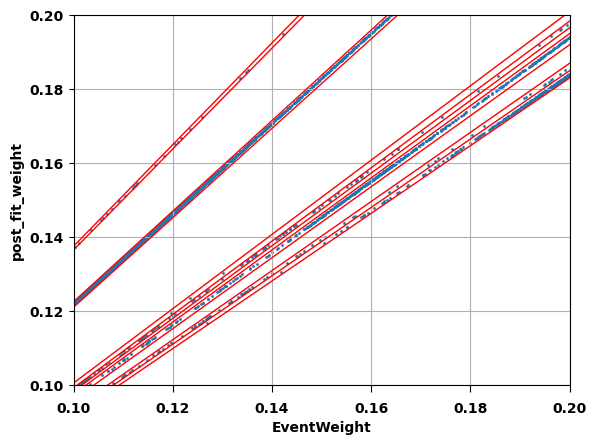

In [31]:
ax = plt.subplot()
ax.scatter(df_train['EventWeight'], df_train['post_fit_weight'], s=1)
ax.set_xlabel('EventWeight')
ax.set_ylabel('post_fit_weight')
ax.grid()
ax.set_xlim(0.1,0.2)
ax.set_ylim(0.1,0.2)

xspace = np.linspace(0.1,0.2)

def bounding_lines(grads):
  for grad in grads:
    plt.plot(xspace,grad*xspace,color='r',linewidth=1)

bounding_lines([0.915,0.925,0.935,0.96,0.975,0.983,0.992,1.005,1.21,1.225,1.365,1.375])

In [32]:
def filter_coeff_ratio(df, nom, denom, ranges, column):
  # column should either be 'sample' (finer) or 'category' (coarser)
  stats_df = pd.DataFrame(columns = ['slope range', column])
  # find a way to get the stuff into a nice dataframe
  coeff_ratio = df[nom]/df[denom]
  ax = plt.subplot()
  color_patches = []
  for i in range(len(ranges)-1):
    filter = (coeff_ratio >= ranges[i]) & (coeff_ratio <= ranges[i+1])
    if len(df[filter]) != 0:
      line = ax.plot(df[filter][denom], df[filter][nom], '.', markersize=2, alpha=0.5)
      color_patches.append(mpl.patches.Patch(color=line[0].get_color(), label=f"{ranges[i]} - {ranges[i+1]}"))
      stats_df.loc[len(stats_df)] = [f"{ranges[i]} - {ranges[i+1]}", str(df[filter][column].value_counts().to_dict())]
  plt.xlabel(denom)
  plt.ylabel(nom)
  #ax.set_xlim(0.06,0.1)
  #ax.set_ylim(0.06,0.1)
  ax.legend(handles = color_patches)
  ax.grid()
  return stats_df

,slope range,sample
0,0.915 - 0.925,{'ttbar': 6574}
1,0.925 - 0.935,"{'Wl': 2013, 'Wcl': 971}"
2,0.96 - 0.975,"{'stops': 1605, 'stopt': 1112, 'stopWt': 684}"
3,0.983 - 0.992,"{'WZ': 789, 'Zl': 288, 'ZZ': 133, 'WW': 105}"
4,0.992 - 1.005,"{'qqWlvH125': 45550, 'qqZllH125': 4310, 'ggZll..."
5,1.21 - 1.225,"{'Wbb': 8791, 'Wbc': 714, 'Wcc': 683, 'Wbl': 411}"
6,1.365 - 1.375,"{'Zbb': 1565, 'Zcc': 80, 'Zbl': 69, 'Zbc': 59}"


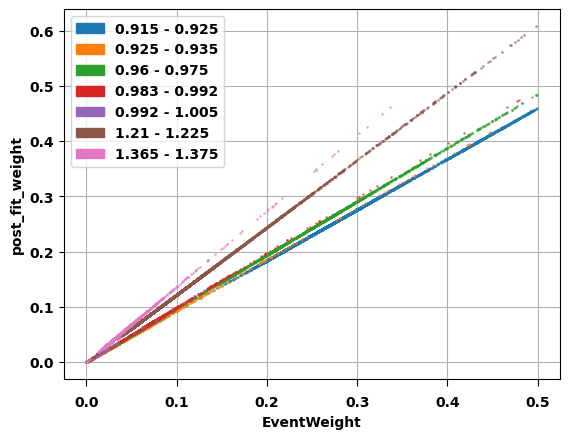

In [33]:
# filtering out different linear trends between post_fit_weight/training and EventWeight to 'reverse engineer' what contributes to the coefficients
postfit_Event_df = filter_coeff_ratio(df_train, 'post_fit_weight', 'EventWeight', [0.915,0.925,0.935,0.96,0.975,0.983,0.992,1.005,1.21,1.225,1.365,1.375], 'sample')
postfit_Event_df

,slope range,sample
0,0 - 750,"{'Wbb': 8791, 'ttbar': 6562, 'Wl': 2013, 'stop..."
1,750 - 3000,"{'qqWlvH125': 45550, 'qqZllH125': 4310, 'ggZll..."


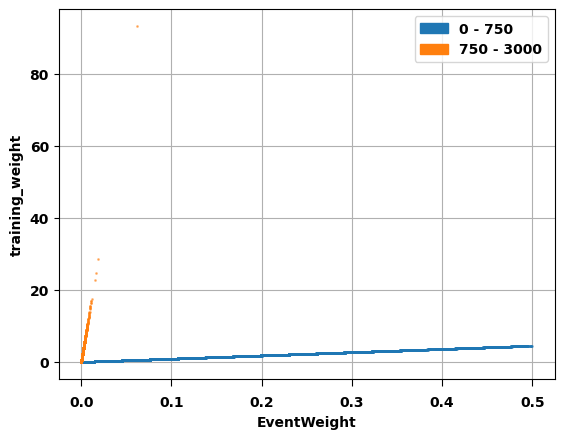

In [34]:
training_Event_df = filter_coeff_ratio(df_train, 'training_weight', 'EventWeight', [0,750,3000], 'sample')
training_Event_df

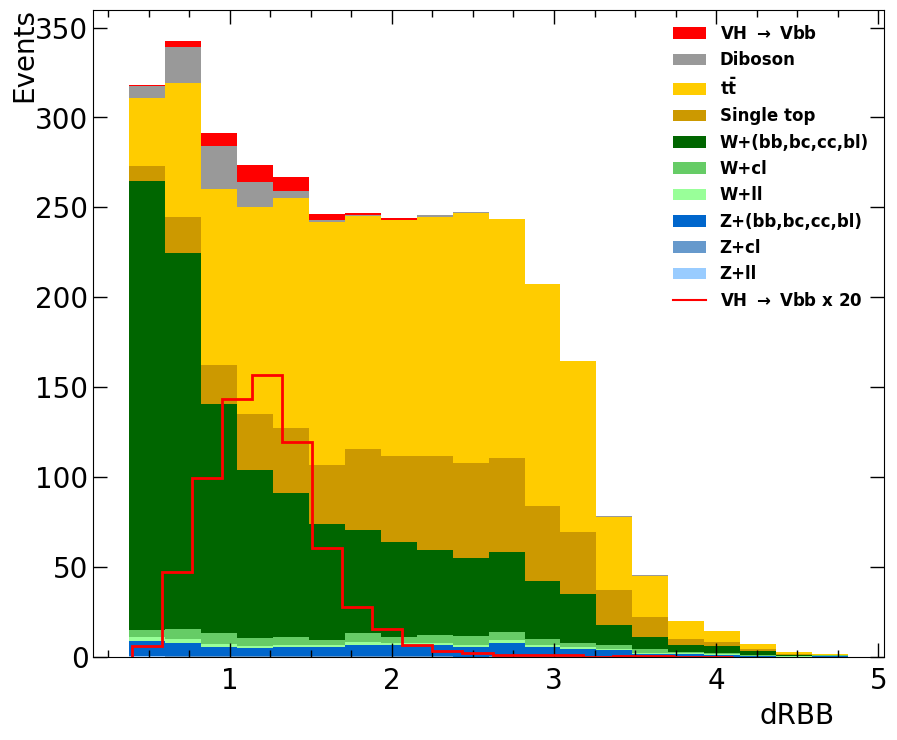

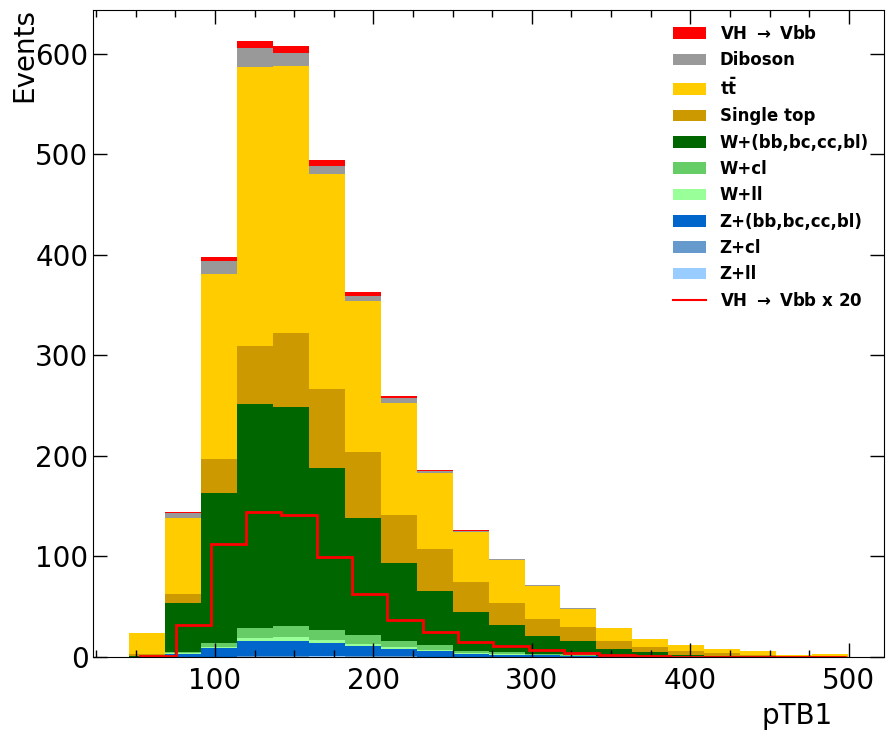

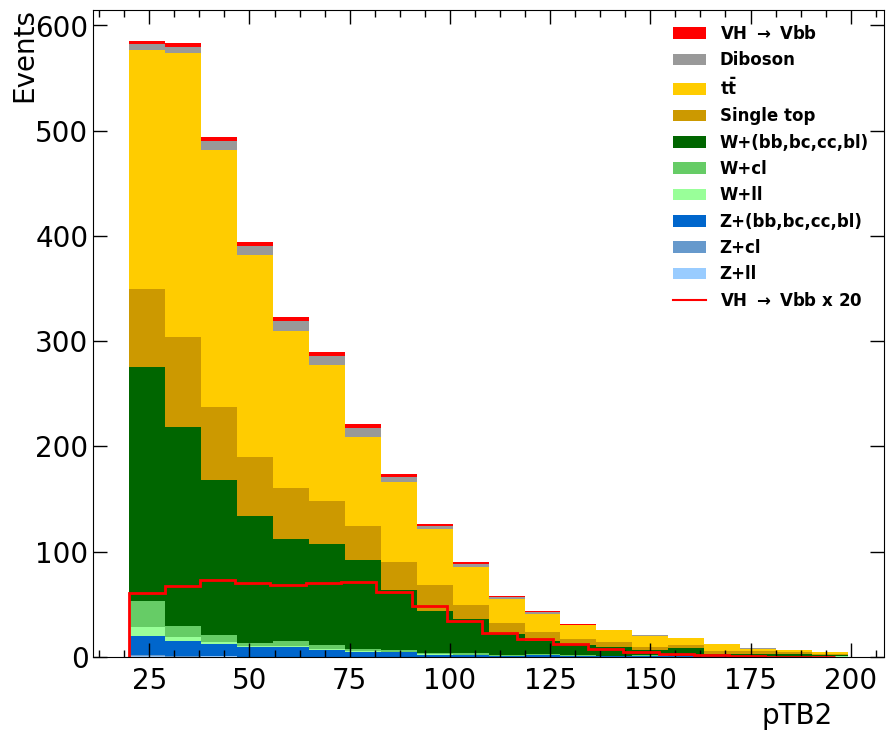

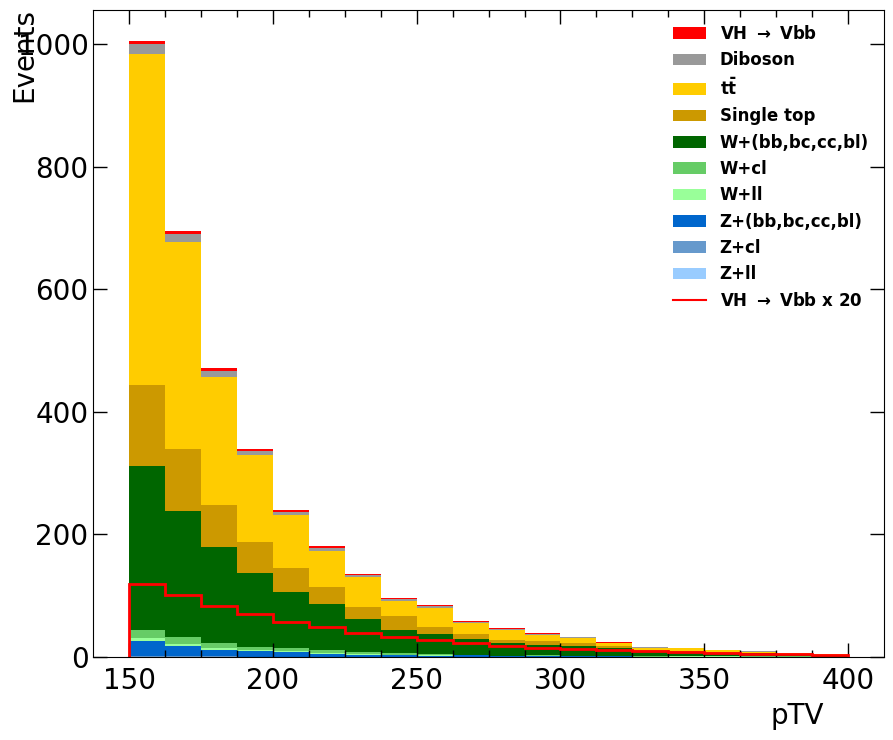

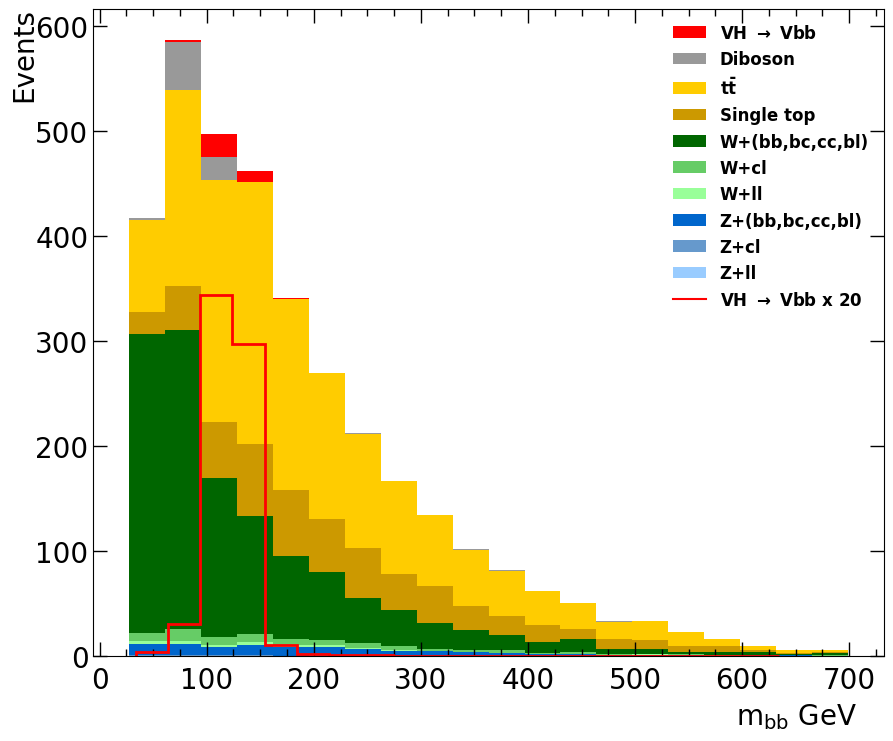

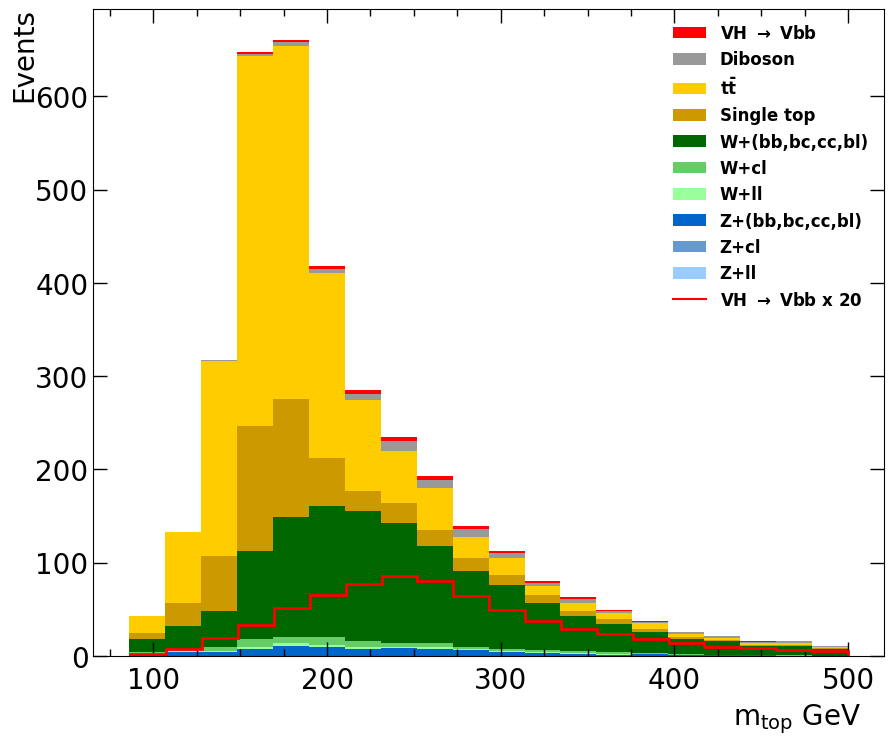

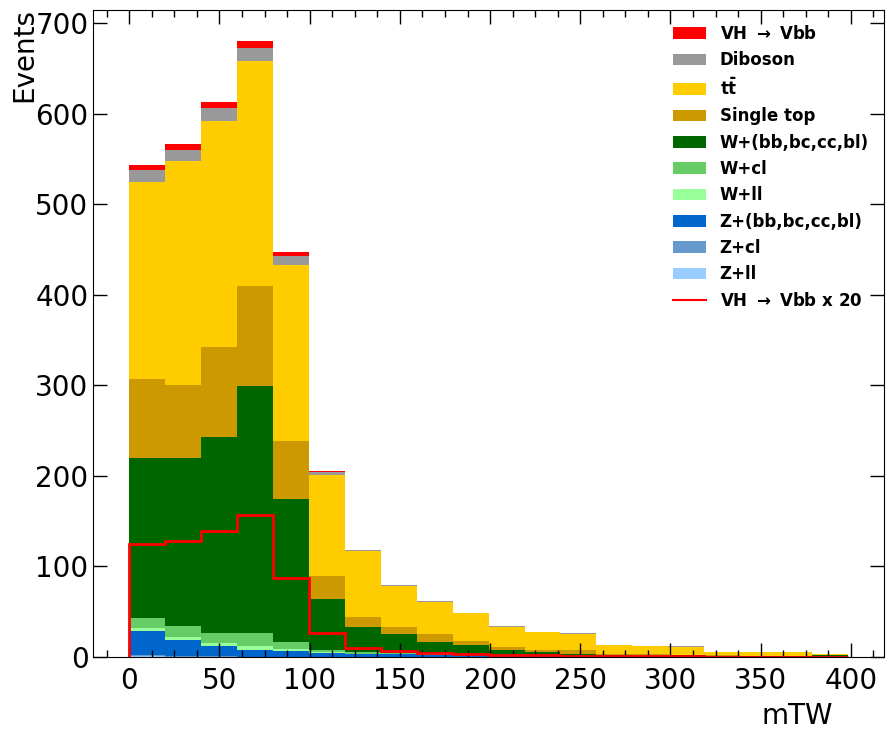

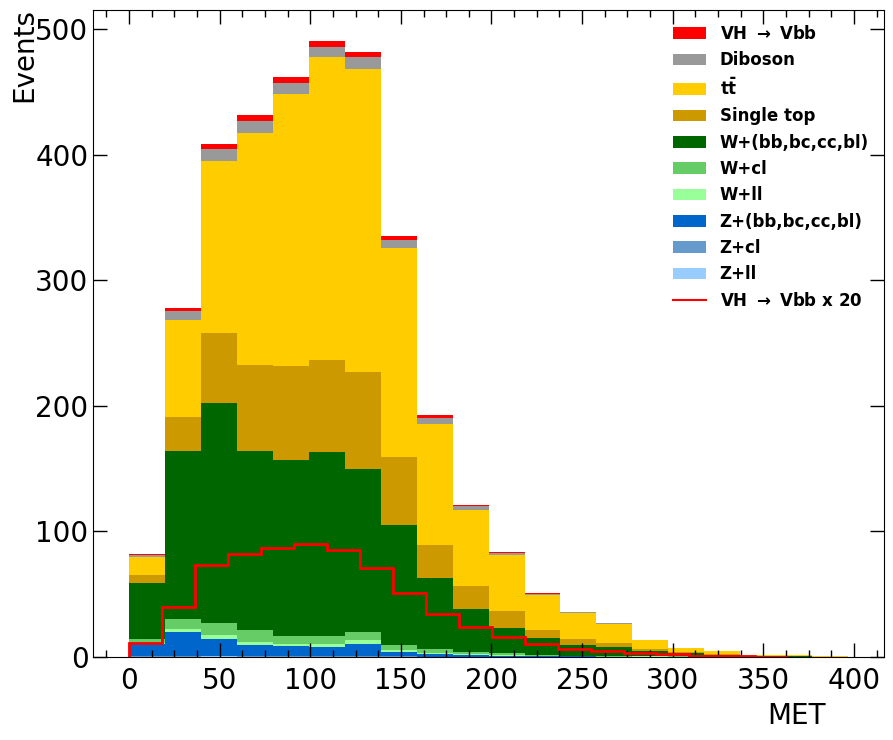

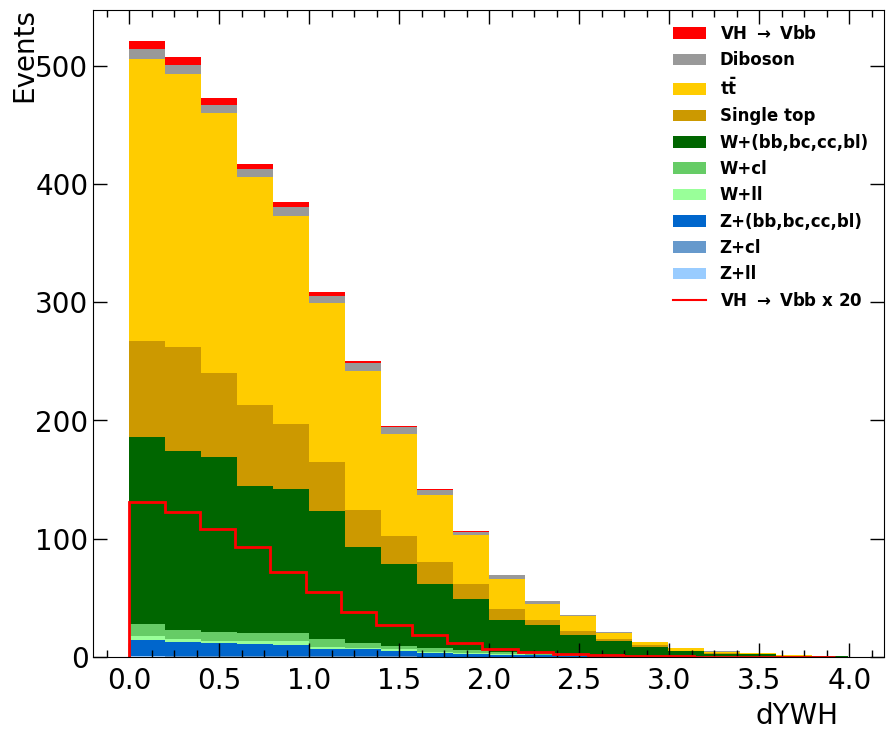

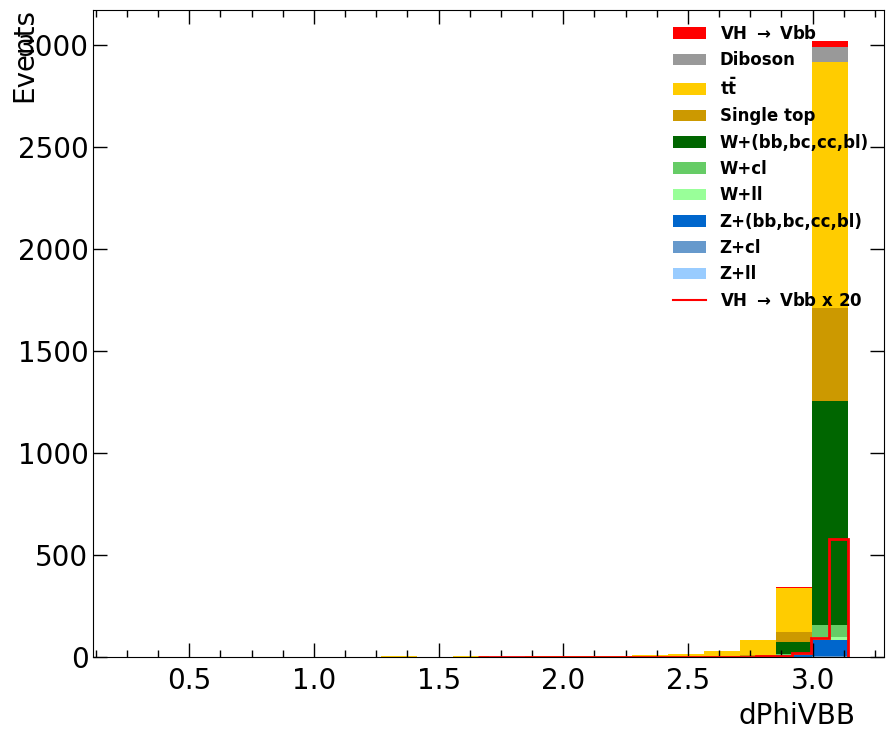

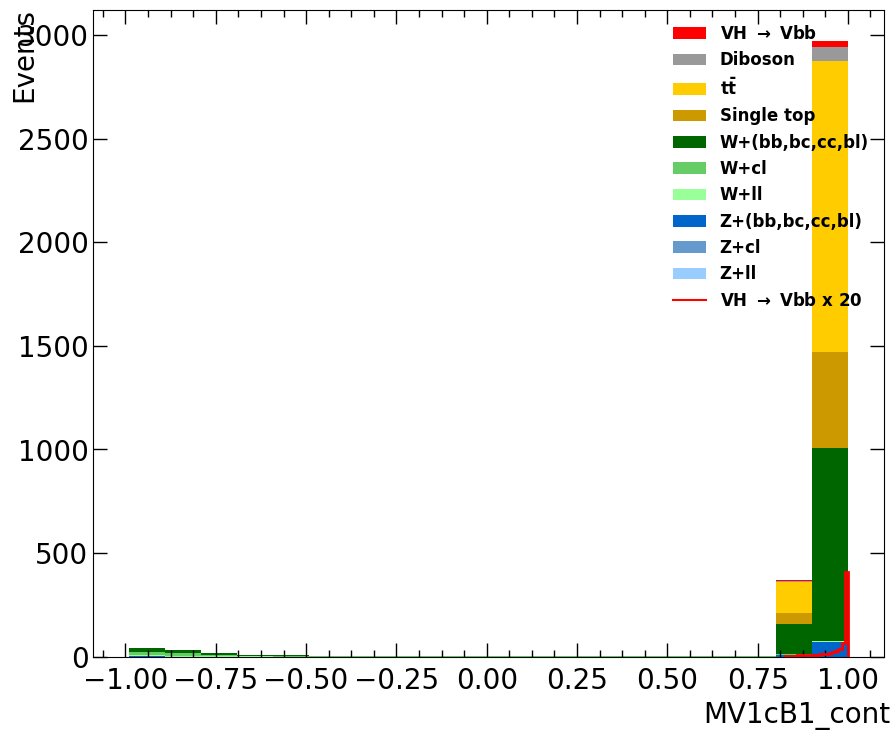

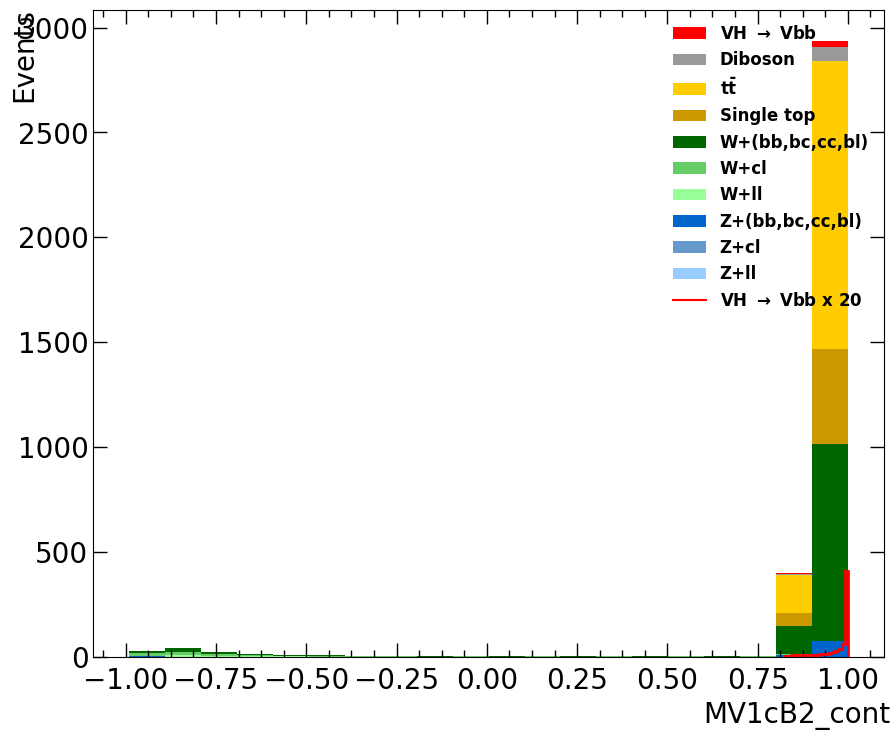

In [35]:
# seem to be an issue when graphing the histograms for variables including pTB1/2
# - histograms are not scaled by the same 1/1e3 factor
# - has been fixed by modifying ucl_masterclass.py

for var in ['dRBB', 'pTB1', 'pTB2', 'pTV', 'mBB',
            'Mtop', 'mTW', 'MET', 'dYWH', 'dPhiVBB',
            'MV1cB1_cont', 'MV1cB2_cont']:
  plot_variable(df_train, var)

# variables that show promise include dRBB, Mtop, dPhiVBB, MV1cB1_cont and MV1cB2_cont

In [41]:
# greedy algorithm - grid search across all variables, find greatest
# how would we find the gradient in this case for SGD?

# manual:

# Apply cut
df_trim1 = df_train[df_train['Mtop']/1e3 > 250] #Mtop above 220GeV

# The code below plots the mBB distribution after selection is applied
plot_variable(df_trim1, 'mBB')

# The code below plots the mBB distribution before any selection is applied
plot_variable(df_train,'mBB')

# Calculate and output the sensitivity based up the original mBB distribution prior to any selection
# The sensitivity is calculated using the profile likelihood ratio test and Asimov approach
print("Sensitivity achieved before cuts ",sensitivity_cut_based(df_train))

# The code below plots the mBB distribution after the selection has applied
plot_variable(df_trim1,'mBB')

# Calculate and output the sensitivity based up the mBB distribution after the selectoin has been applied
print("Sensitivity achieved after cuts ",sensitivity_cut_based(df_trim1))

Sensitivity achieved after cuts  1.3275600693415317


In [236]:
def grid_search_cutting(df, var, cut_range, n_cuts):
  """
  df: dataframe to cut on
  var: variable to cut on
  cut_range: range of cuts to try.
    Can be a list of 2 values (1 shared range for lb and ub), or
    Can be a list of 4 values (range for lb, range for ub)
  n_cuts: number of cuts to try within range. DO NOT SET THIS TOO HIGH (>20)
  Each cut will be cut_range/(n_cuts - 1) apart.

  Preliminary search on a coarser grain, hoping to find a rough area to focus on.
  Dependent on sensitivity_cut_based().
  """
  sens_dict = {}

  if len(cut_range) == 4: # set up upper and lower bounds
    cut_lb = np.linspace(*cut_range[:2], n_cuts)
    cut_ub = np.linspace(*cut_range[2:], n_cuts)
  else:
    cut_lb = np.linspace(*cut_range, n_cuts)
    cut_ub = np.linspace(*cut_range, n_cuts)

  for i in range(n_cuts): #lower bound
    for j in range(n_cuts): #upper bound

      if cut_lb[i] >= cut_ub[j]: # skip if lower bound exceeds upper bound
        sens_dict[i * n_cuts + j] = [cut_lb[i], cut_ub[j], np.nan]

      else:
        df_cut = df[(df[var] > cut_lb[i]) & (df[var] < cut_ub[j])]
        sens_val = sensitivity_cut_based(df_cut)

        sens_dict[i * n_cuts + j] = [cut_lb[i], cut_ub[j], (sens_val if sens_val != np.inf else 0)]

  sens_df = pd.DataFrame.from_dict(sens_dict, orient='index',columns=['lower_bound', 'upper_bound', 'sensitivity'])
  sens_df['lower_bound'] = sens_df['lower_bound'].round(5)
  sens_df['upper_bound'] = sens_df['upper_bound'].round(5)

  sens_pivot = sens_df.pivot(index='lower_bound', columns='upper_bound', values='sensitivity')

  return sens_pivot


In [ ]:
# you spin me right round baby right round
def iterated_grid_search(df, vars, n_cuts, max_depth=3):
  max_vars = []
  lbs = []
  ubs = []

  for i in tqdm(range(max_depth)):
    max_sens = 0
    max_matrix = []

    for var in vars:
      var_matrix = grid_search_cutting(df, var, [df[var].min(), df[var].max()], n_cuts)
      if np.max(var_matrix) > max_sens:
        max_var = var
        max_sens = np.max(var_matrix)
        max_matrix = var_matrix

    unstacked_multi = max_matrix.unstack()
    unstacked_df = unstacked_multi[unstacked_multi == max_sens].reset_index()
    lb = unstacked_df['lower_bound'][0]
    ub = unstacked_df['upper_bound'][0]

    max_vars.append(max_var)
    lbs.append(lb)
    ubs.append(ub)

    df = df[(df[var] > lb) & (df[var] < ub)]

  return df

In [300]:
print(df_train['dRBB'].max())

4.812890052799999


In [302]:
#from time import sleep

In [304]:
# DO NOT RUN UNLESS YOU WANT TO WAIT FOREVER
# HOPING THIS DOESN"T TIME OUT
# SHOULD TRY AND RECODE THE sens function TO MEMOISE

#I've commented out the for condition just so that this doesn't actually run unless deliberately chosen

#max_sens = {}
#matrices = []

#vars_to_search = ['dRBB', 'pTB1', 'pTB2', 'pTV', 'mBB',
            'Mtop', 'mTW', 'MET', 'dYWH', 'dPhiVBB',
            'MV1cB1_cont', 'MV1cB2_cont']

#for var in tqdm(vars_to_search):
  var_matrix = grid_search_cutting(df_train, var, [df_train[var].min(), df_train[var].max()], 51)
  matrices.append(var_matrix)
  max_sens[var] = np.max(var_matrix)


  0%|          | 0/12 [00:00<?, ?it/s]/content/ucl_masterclass.py:538: RuntimeWarning: invalid value encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin
/content/ucl_masterclass.py:538: RuntimeWarning: divide by zero encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin
100%|██████████| 12/12 [18:36<00:00, 93.08s/it]


In [306]:
for key, value in max_sens.items():
  print(f"{key}: {value}")

dRBB: 1.5423346049912858
pTB1: 1.2625731782685894
pTB2: 1.3914329521621194
pTV: 1.2696209041761197
mBB: 1.2523998128534815
Mtop: 1.4947063098642601
mTW: 1.2849331120903116
MET: 1.251472569002585
dYWH: 1.2640262477047413
dPhiVBB: 1.326508759425112
MV1cB1_cont: 1.2754412537823563
MV1cB2_cont: 1.27592868852976


In [352]:
unstacked_multi = matrices[0].unstack()

unstacked_df = unstacked_multi[unstacked_multi == max_sens['dRBB']].reset_index()
lb1 = unstacked_df['lower_bound']
ub1 = unstacked_df['upper_bound']

   upper_bound  lower_bound         0
0      1.35559      0.38046  1.542335
0.38046 1.35559


In [353]:
df_trim1 = df_train[(df_train['dRBB'] > lb1) & (df_train['dRBB'] < ub1)]

In [354]:
sensitivity_cut_based(df_trim1)

1.5423346049912858

In [355]:
#round 2 lesgo
max_sens_2 = {}
matrices_2 = []

vars_to_search = ['dRBB', 'pTB1', 'pTB2', 'pTV', 'mBB',
            'Mtop', 'mTW', 'MET', 'dYWH', 'dPhiVBB',
            'MV1cB1_cont', 'MV1cB2_cont']

for var in tqdm(vars_to_search):
  var_matrix = grid_search_cutting(df_trim1, var, [df_trim1[var].min(), df_trim1[var].max()], 51)
  matrices_2.append(var_matrix)
  max_sens_2[var] = np.max(var_matrix)

  0%|          | 0/12 [00:00<?, ?it/s]/content/ucl_masterclass.py:538: RuntimeWarning: invalid value encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin
/content/ucl_masterclass.py:538: RuntimeWarning: divide by zero encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin
100%|██████████| 12/12 [15:36<00:00, 78.03s/it]


In [359]:
max_key = '' # this is lazy ik
max_val = 0
for key, value in max_sens_2.items():
  print(f"{key}: {value}")
  if value > max_val:
    max_val = value
    max_key = key

print('\n')
print(max_key, max_val)


dRBB: 1.5421886571633112
pTB1: 1.5423260127565164
pTB2: 1.5504659328872505
pTV: 1.5422332100217646
mBB: 1.5652760397893097
Mtop: 1.5657547301762171
mTW: 1.5527339975883032
MET: 1.5421090842492267
dYWH: 1.5540830951571067
dPhiVBB: 1.5585931097569088
MV1cB1_cont: 1.5831488579221349
MV1cB2_cont: 1.5790663893591466


MV1cB1_cont 1.5831488579221349


In [369]:
unstacked_multi_2 = matrices_2[-2].unstack()

unstacked_df_2 = unstacked_multi_2[unstacked_multi_2 == max_sens_2['MV1cB1_cont']].reset_index()
lb2 = unstacked_df_2['lower_bound'][0]
ub2 = unstacked_df_2['upper_bound'][0]
print(lb2, ub2)

0.88063 1.0


In [372]:
df_trim2 = df_trim1[(df_trim1['MV1cB1_cont'] > lb2) & (df_trim1['MV1cB1_cont'] < ub2)]

In [373]:
sensitivity_cut_based(df_trim2)

1.583154450825163

In [374]:
# round 3

max_sens_3 = {}
matrices_3 = []

vars_to_search = ['dRBB', 'pTB1', 'pTB2', 'pTV', 'mBB',
            'Mtop', 'mTW', 'MET', 'dYWH', 'dPhiVBB',
            'MV1cB1_cont', 'MV1cB2_cont']

for var in tqdm(vars_to_search):
  var_matrix = grid_search_cutting(df_trim2, var, [df_trim2[var].min(), df_trim2[var].max()], 51)
  matrices_3.append(var_matrix)
  max_sens_3[var] = np.max(var_matrix)

  0%|          | 0/12 [00:00<?, ?it/s]/content/ucl_masterclass.py:538: RuntimeWarning: invalid value encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin
/content/ucl_masterclass.py:538: RuntimeWarning: divide by zero encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin
100%|██████████| 12/12 [15:16<00:00, 76.38s/it]


In [376]:
max_key = '' # this is lazy ik
max_val = 0
for key, value in max_sens_3.items():
  print(f"{key}: {value}")
  if value > max_val:
    max_val = value
    max_key = key

print('\n')
print(max_key, max_val)

dRBB: 1.5829936404309357
pTB1: 1.583145257335853
pTB2: 1.5888585360405731
pTV: 1.5830445487314095
mBB: 1.6075421336283522
Mtop: 1.60850226600794
mTW: 1.5868455110419155
MET: 1.582907065552978
dYWH: 1.5956837770987193
dPhiVBB: 1.598675784076632
MV1cB1_cont: 1.588531915854682
MV1cB2_cont: 1.5994618407359809


Mtop 1.60850226600794


In [378]:
unstacked_multi_3 = matrices_3[5].unstack()

unstacked_df_3 = unstacked_multi_3[unstacked_multi_3 == max_sens_3['Mtop']].reset_index()
lb3 = unstacked_df_3['lower_bound'][0]
ub3 = unstacked_df_3['upper_bound'][0]
print(lb3, ub3)

197422.28281 499972.375


In [379]:
df_trim3 = df_trim2[(df_trim2['Mtop'] > lb3) & (df_trim2['Mtop'] < ub3)]

In [380]:
sensitivity_cut_based(df_trim3)

1.60850226600794

In [382]:
# round 4

max_sens_4 = {}
matrices_4 = []

vars_to_search = ['dRBB', 'pTB1', 'pTB2', 'pTV', 'mBB',
            'Mtop', 'mTW', 'MET', 'dYWH', 'dPhiVBB',
            'MV1cB1_cont', 'MV1cB2_cont']

for var in tqdm(vars_to_search):
  var_matrix = grid_search_cutting(df_trim3, var, [df_trim3[var].min(), df_trim3[var].max()], 51)
  matrices_4.append(var_matrix)
  max_sens_4[var] = np.max(var_matrix)

  0%|          | 0/12 [00:00<?, ?it/s]/content/ucl_masterclass.py:538: RuntimeWarning: invalid value encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin
/content/ucl_masterclass.py:538: RuntimeWarning: divide by zero encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin
100%|██████████| 12/12 [15:56<00:00, 79.72s/it]


In [21]:
dRBB_matrix = grid_search_cutting(df_train, 'dRBB', [0,5], 21)

/content/ucl_masterclass.py:538: RuntimeWarning: invalid value encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin
/content/ucl_masterclass.py:538: RuntimeWarning: divide by zero encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin


<Axes: xlabel='upper_bound', ylabel='lower_bound'>

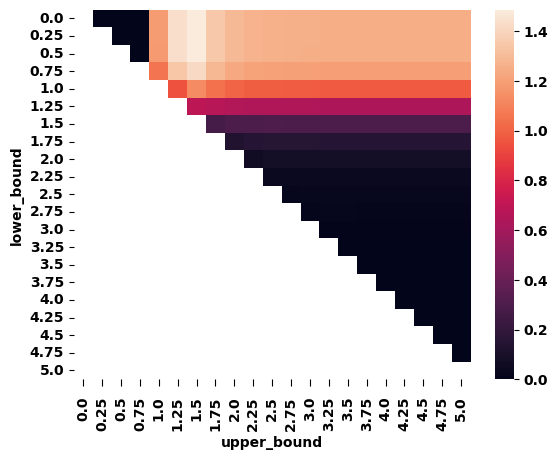

In [22]:
sns.heatmap(dRBB_matrix, annot=False, fmt=".2f")

In [283]:
dRBB_matrix_fine = grid_search_cutting(df_train, 'dRBB', [0,0.3,1.352,1.367], 6)

In [299]:


#sns.heatmap(dRBB_matrix_fine, annot=True, fmt=".3f")
np.nonzero(dRBB_matrix_fine == np.max(dRBB_matrix_fine))
dRBB_matrix_fine

upper_bound,1.352,1.355,1.358,1.361,1.364,1.367
lower_bound,,,,,,
0.00,1.539155,1.541097,1.545694,1.543418,1.546143,1.543626
0.06,1.539155,1.541097,1.545694,1.543418,1.546143,1.543626
0.12,1.539155,1.541097,1.545694,1.543418,1.546143,1.543626
0.18,1.539155,1.541097,1.545694,1.543418,1.546143,1.543626
0.24,1.539155,1.541097,1.545694,1.543418,1.546143,1.543626
0.30,1.539155,1.541097,1.545694,1.543418,1.546143,1.543626


In [220]:
Mtop_matrix = grid_search_cutting(df_train, 'Mtop', [50*1e3,500*1e3], 21)

/content/ucl_masterclass.py:538: RuntimeWarning: invalid value encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin
/content/ucl_masterclass.py:538: RuntimeWarning: divide by zero encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin


<Axes: xlabel='upper_bound', ylabel='lower_bound'>

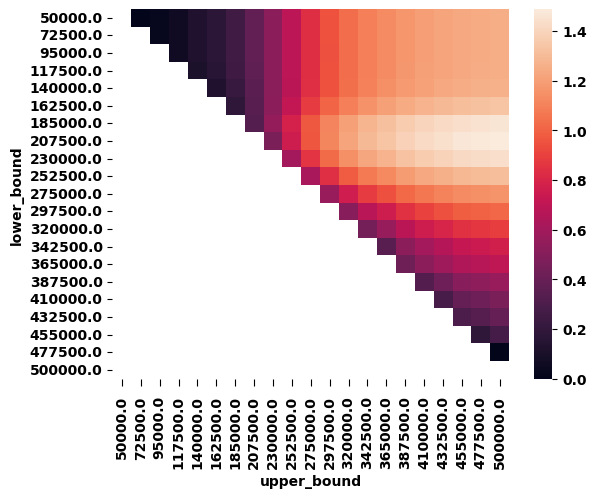

In [222]:
#Mtop_matrix
sns.heatmap(Mtop_matrix, annot=False)

In [225]:
Mtop_matrix_fine = grid_search_cutting(df_train, 'Mtop', [192500,222500,440000,500000], 5)

<Axes: xlabel='upper_bound', ylabel='lower_bound'>

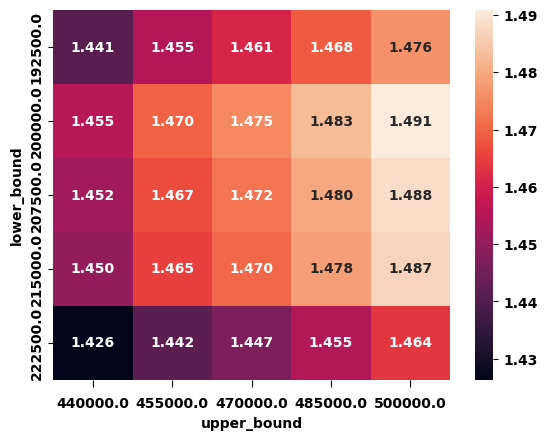

In [226]:
sns.heatmap(Mtop_matrix_fine, annot=True, fmt=".3f")

In [228]:
dPhiVBB_matrix = grid_search_cutting(df_train, 'dPhiVBB', [1,3], 21)

/content/ucl_masterclass.py:538: RuntimeWarning: invalid value encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin
/content/ucl_masterclass.py:538: RuntimeWarning: divide by zero encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin


<Axes: xlabel='upper_bound', ylabel='lower_bound'>

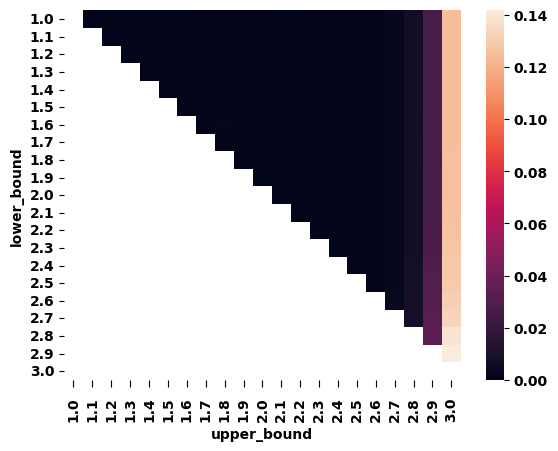

In [229]:
sns.heatmap(dPhiVBB_matrix, annot=False)

In [246]:
dPhiVBB_matrix_fine = grid_search_cutting(df_train, 'dPhiVBB', [2.875,2.91,2.96,3.0], 5)

<Axes: xlabel='upper_bound', ylabel='lower_bound'>

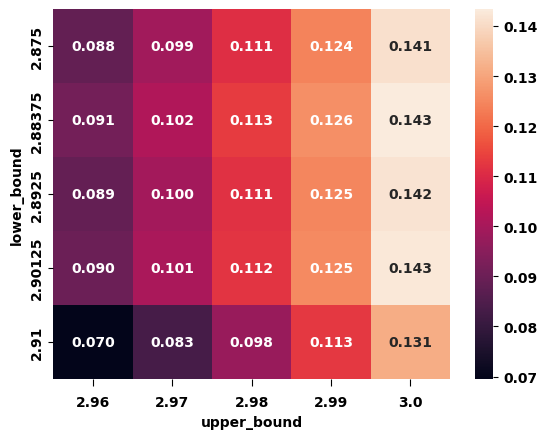

In [247]:
sns.heatmap(dPhiVBB_matrix_fine, annot=True, fmt=".3f")

In [248]:
dYWH_matrix = grid_search_cutting(df_train, 'dYWH', [0,4], 21)

/content/ucl_masterclass.py:538: RuntimeWarning: invalid value encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin


<Axes: xlabel='upper_bound', ylabel='lower_bound'>

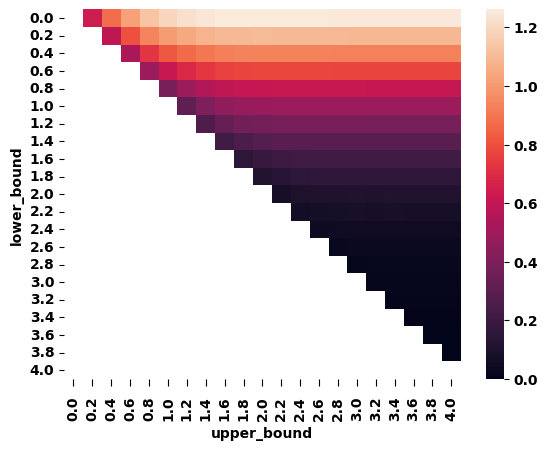

In [249]:
sns.heatmap(dYWH_matrix, annot=False)

In [258]:
dYWH_matrix_fine = grid_search_cutting(df_train, 'dYWH', [0,0.015,1.5,2], 6)

<Axes: xlabel='upper_bound', ylabel='lower_bound'>

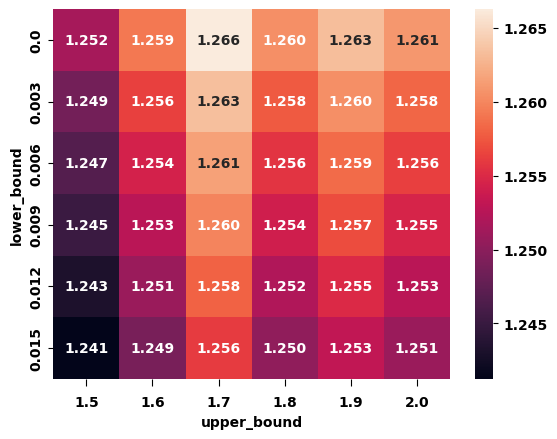

In [259]:
sns.heatmap(dYWH_matrix_fine, annot=True, fmt=".3f")

In [263]:
MET_matrix = grid_search_cutting(df_train, 'MET', [0,400*1e3], 21)

/content/ucl_masterclass.py:538: RuntimeWarning: invalid value encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin


<Axes: xlabel='upper_bound', ylabel='lower_bound'>

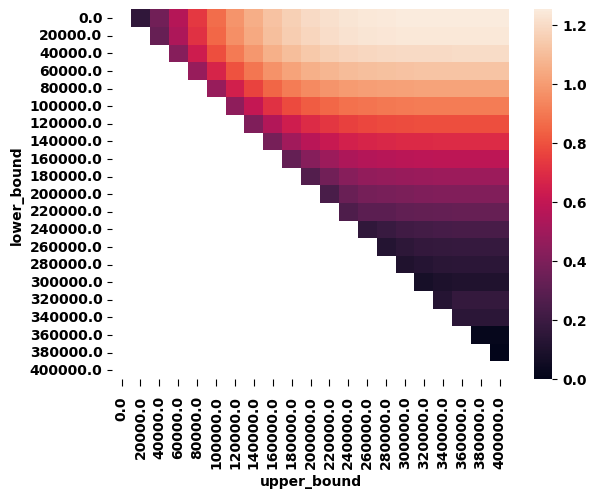

In [264]:
sns.heatmap(MET_matrix, annot=False)

In [271]:
MET_matrix_fine = grid_search_cutting(df_train, 'MET', [0,15000,300000,400000], 6)

<Axes: xlabel='upper_bound', ylabel='lower_bound'>

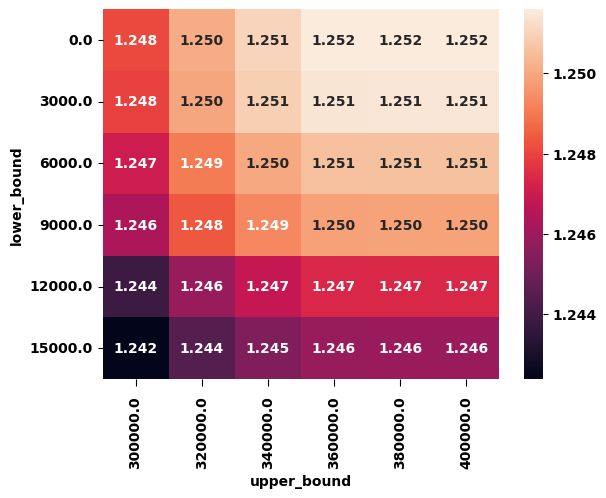

In [272]:
sns.heatmap(MET_matrix_fine, annot=True, fmt=".3f")

In [273]:
mTW_matrix = grid_search_cutting(df_train, 'mTW', [0,400*1e3], 21)

/content/ucl_masterclass.py:538: RuntimeWarning: invalid value encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin
/content/ucl_masterclass.py:538: RuntimeWarning: divide by zero encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin


<Axes: xlabel='upper_bound', ylabel='lower_bound'>

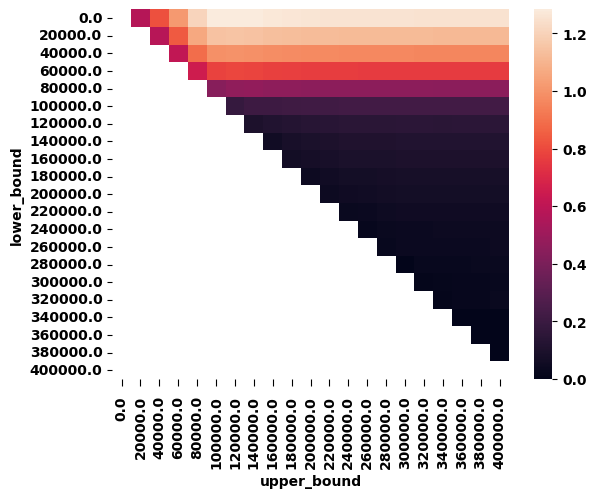

In [274]:
sns.heatmap(mTW_matrix, annot=False)

In [277]:
mTW_matrix_fine = grid_search_cutting(df_train, 'mTW', [0,20000,80000,180000], 6)

<Axes: xlabel='upper_bound', ylabel='lower_bound'>

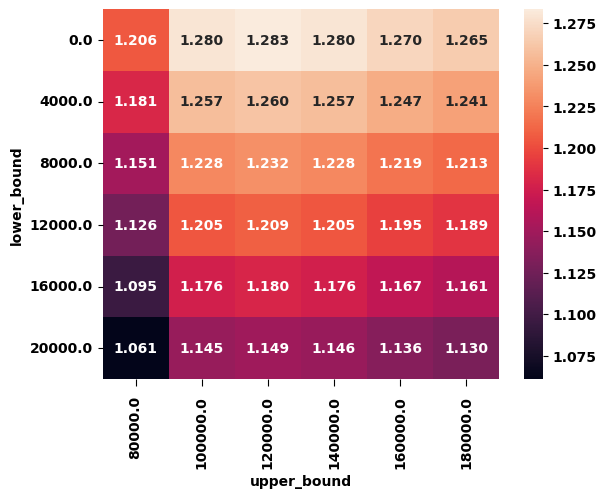

In [278]:
sns.heatmap(mTW_matrix_fine, annot=True, fmt=".3f")

Sensitivity achieved before cut  1.2515837472281321
Sensitivity achieved after cut   1.5461434010298734


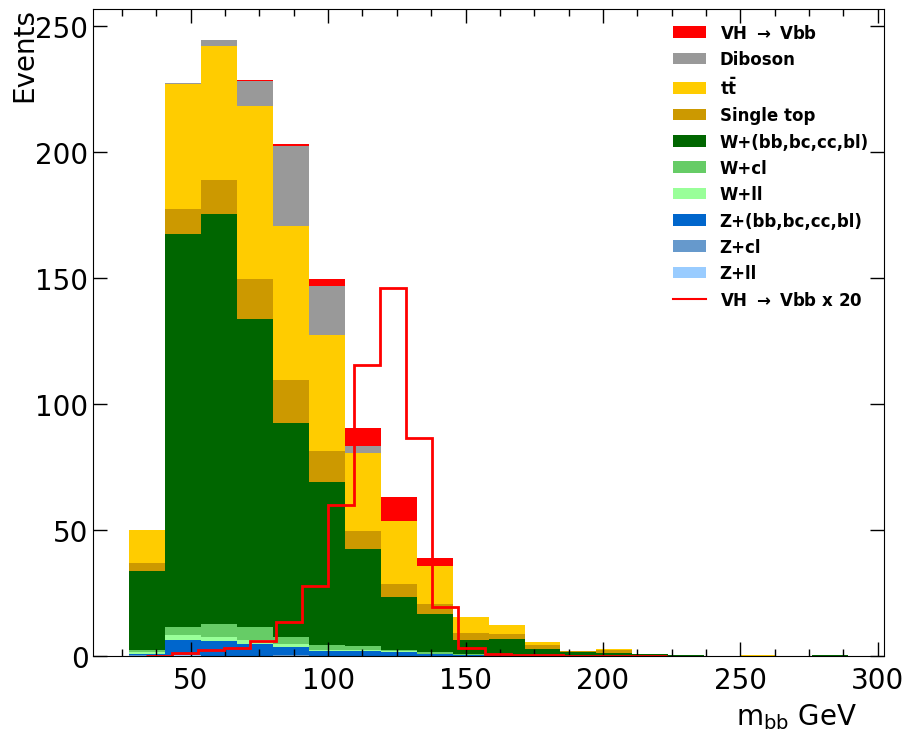

In [286]:
df_trim2 = df_train[df_train['dRBB'] < 1.364]

print("Sensitivity achieved before cut ",sensitivity_cut_based(df_train))
print("Sensitivity achieved after cut  ",sensitivity_cut_based(df_trim2))

plot_variable(df_trim2, 'mBB')

Old `grid_search_cutting_fine` function: used to be separate to `grid_search_cutting` as the latter didn't have a function for separate lower and upper ranges.

In [100]:
# def grid_search_cutting_fine(df, var, lower_range, upper_range, n_cuts):
#   """
#   df: dataframe to cut on
#   var: variable to cut on
#   lower_range: lower range of cuts to try
#   upper_range: upper range of cuts to try
#   n_cuts: number of cuts to try within each range. DO NOT SET THIS TOO HIGH (>20)
#   Each cut will be range/(n_cuts - 1) apart.

#   Dependent on sensitivity_cut_based().
#   Finer search once grid_search_cutting has been used
#   """
#   sens_dict = {}
#   lower_cuts = np.linspace(*lower_range, n_cuts)
#   upper_cuts = np.linspace(*upper_range, n_cuts) #haha funny uppercut get it
#   for i in range(n_cuts): #lower bound
#     for j in range(n_cuts): #upper bound
#       df_cut = df[(df[var] > lower_cuts[i]) & (df[var] < upper_cuts[j])]
#       sens_val = sensitivity_cut_based(df_cut)
#       if sens_val != np.inf:
#         sens_dict[i * n_cuts + j] = [lower_cuts[i], upper_cuts[j], sens_val]
#       else:
#         sens_dict[i * n_cuts + j] = [lower_cuts[i], upper_cuts[j], 0]

#   sens_df = pd.DataFrame.from_dict(sens_dict, orient='index',columns=['lower_bound', 'upper_bound', 'sensitivity'])
#   sens_df.reindex(index=sens_df.index[::-1])
#   sens_df['lower_bound'] = sens_df['lower_bound'].round(2)
#   sens_df['upper_bound'] = sens_df['upper_bound'].round(2)
#   sens_pivot = sens_df.pivot(index='lower_bound', columns='upper_bound', values='sensitivity')

#   return sens_pivot